In [1]:
cd /home/karen/Documents/GitHub/Muscle_wasting

/home/karen/Documents/GitHub/Muscle_wasting


/home/karen/Documents/GitHub/Muscle_wasting/venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# USE CASE 2

-- oNetwork: "UseCases/UseCase2/usecase2.cyjs"
-- path_DDS_data: "UseCases/UseCase2/dds_join.csv"
-- path_tissue_data: "/home/karen/Documents/GitHub/Muscle_wasting/data/gene_tissue_Sarcopenia_relevant.csv"
--path_cell_type_data: "/home/karen/Documents/GitHub/Muscle_wasting/data/proportion_cell_type_div_Sarcopenia_relevant.csv"
-- path_pathway_file: "UseCases/UseCase2/pathway_join.csv"
-- path_tf_file: "UseCases/UseCase2/tf_join.csv"
-- page_rank_cutoff: [0.95 0.99]
-- coefficients: {'dds': 20, 'tissue': 1, 'cellular': 1, 'pathway_svd': 1, 'tf': 1, 'miR_enhancement':1}
--network_name UseCase2

In [2]:
import mirna_scoring.walking_network as wn
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mirna_scoring.mirna_impact as mis
import seaborn as sns
import mirna_scoring.mirna_influence_plots as mi_plot
import mirna_scoring.jupyter_functions as jf
from  mirna_scoring.score import *

/home/karen/Documents/GitHub/Muscle_wasting/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from importlib import reload  # Python 3.4+
import mirna_scoring.mirna_impact as mis

In [4]:
from network.network_processing import load_graph

In [5]:
from mirkitten.plot_GSEA_ORA import plot_ora_results

In [6]:
import decoupler as dc
import os

In [7]:
def get_plot_enriched(selected_genes, title):
    enriched = dc.get_ora_df(
            df=selected_genes,
            net=msigdb,
            source='geneset',
            target='genesymbol'
        )
    pathway_df = enriched[enriched['FDR p-value'] < 0.1]
    pathway_df.index = pathway_df["Term"]
    #pathway_df.set_index("Term", inplace=True)  # Set "Term" as index
    enriched_pathways = pathway_df['Combined score']
    return plot_ora_results(pathway_df, top_n=10, figsize=(12, 6), scale_odds_ratio=.5, 
                     fontsize_title=12, fontsize_subtitle=12, fontsize_text=10,title=title)

In [8]:
session_name = 'UseCase_2'

Fisrt we create the output folder for the results

In [9]:
directory='mirna_scoring/results/'+session_name
if not os.path.exists(directory):
    os.makedirs(directory)
    print("Directory created successfully!")
else:
    print("Directory already exists!")

Directory already exists!


And we load the output form MiRNA Network

In [10]:
network = load_graph(f"UseCases/UseCase2/complete_n_tf_mirnas__UseCase2_cutoff_0.9.pkl")
my_network = mis.mirna_network(network=network)

We can just use the function quick scoring, that will score each microRNA for:
- Influence on up and down regulated genes
- Number of Differentially express genes hit
- The weight of the node (calculated on miRKat Network)
- Random walk pathway influence.

This are factual values of the microRNA, there was already a filtering on mirKat Network

In [47]:
scores = my_network.quick_get_all_scores(steps=10, sample_size=100, dds_threshold=2, pathway_keywords=['ATP', 'MUSCLE', "MYO"])

In [12]:
#scores.sort_values(by=['de_count'], ascending = True)

To select the microRNAs, we see 3 factors
- How extreme are their values, if they have heavy outliers it gets added to the list
- Is the top performer on one of the categorties
- It is in the top for several 
- Has the most favorable up regulated genes activation
- Has the most favorable down regulated genes inhibition.

We then get the intersection

In [48]:

top_rows_extreme, row_scores_extreme = select_extreme_rows(scores, x=5, method='iqr')
top_rows_ranked, row_scores_top = select_top_ranked_rows(scores, x=5)
top_rows_ranked_normalized, row_scores_normalized = select_top_normalized_rows(scores, x=5)


In [49]:
mirnas = []
mirnas.extend(top_rows_extreme.index)
mirnas.extend(top_rows_ranked.index)
mirnas.extend(top_rows_ranked_normalized.index)


In [50]:

for comparison in my_network.get_all_available_combinations():
    mir = my_network.get_best_inhibitor_in_comparison(comparison)
    mirnas.append(mir)
    mir = my_network.get_best_activator_in_comparison(comparison)
    mirnas.append(mir)
    

In [51]:
mirnas = list(set(mirnas))
mirnas_selected = mirnas
mirnas

['hsa-miR-15a-5p',
 'hsa-miR-130a-3p',
 'hsa-miR-206',
 'hsa-miR-17-5p',
 'hsa-miR-138-5p',
 'hsa-miR-218-5p',
 'hsa-miR-150-5p',
 'hsa-miR-20a-5p',
 'hsa-miR-107',
 'hsa-miR-124-3p',
 'hsa-miR-106a-5p']

Since many of the mirnas may behave the same, we cluster based on their impact on the genes (how often they reach the gene, if they rach with a -1 or 1) as shown in plot


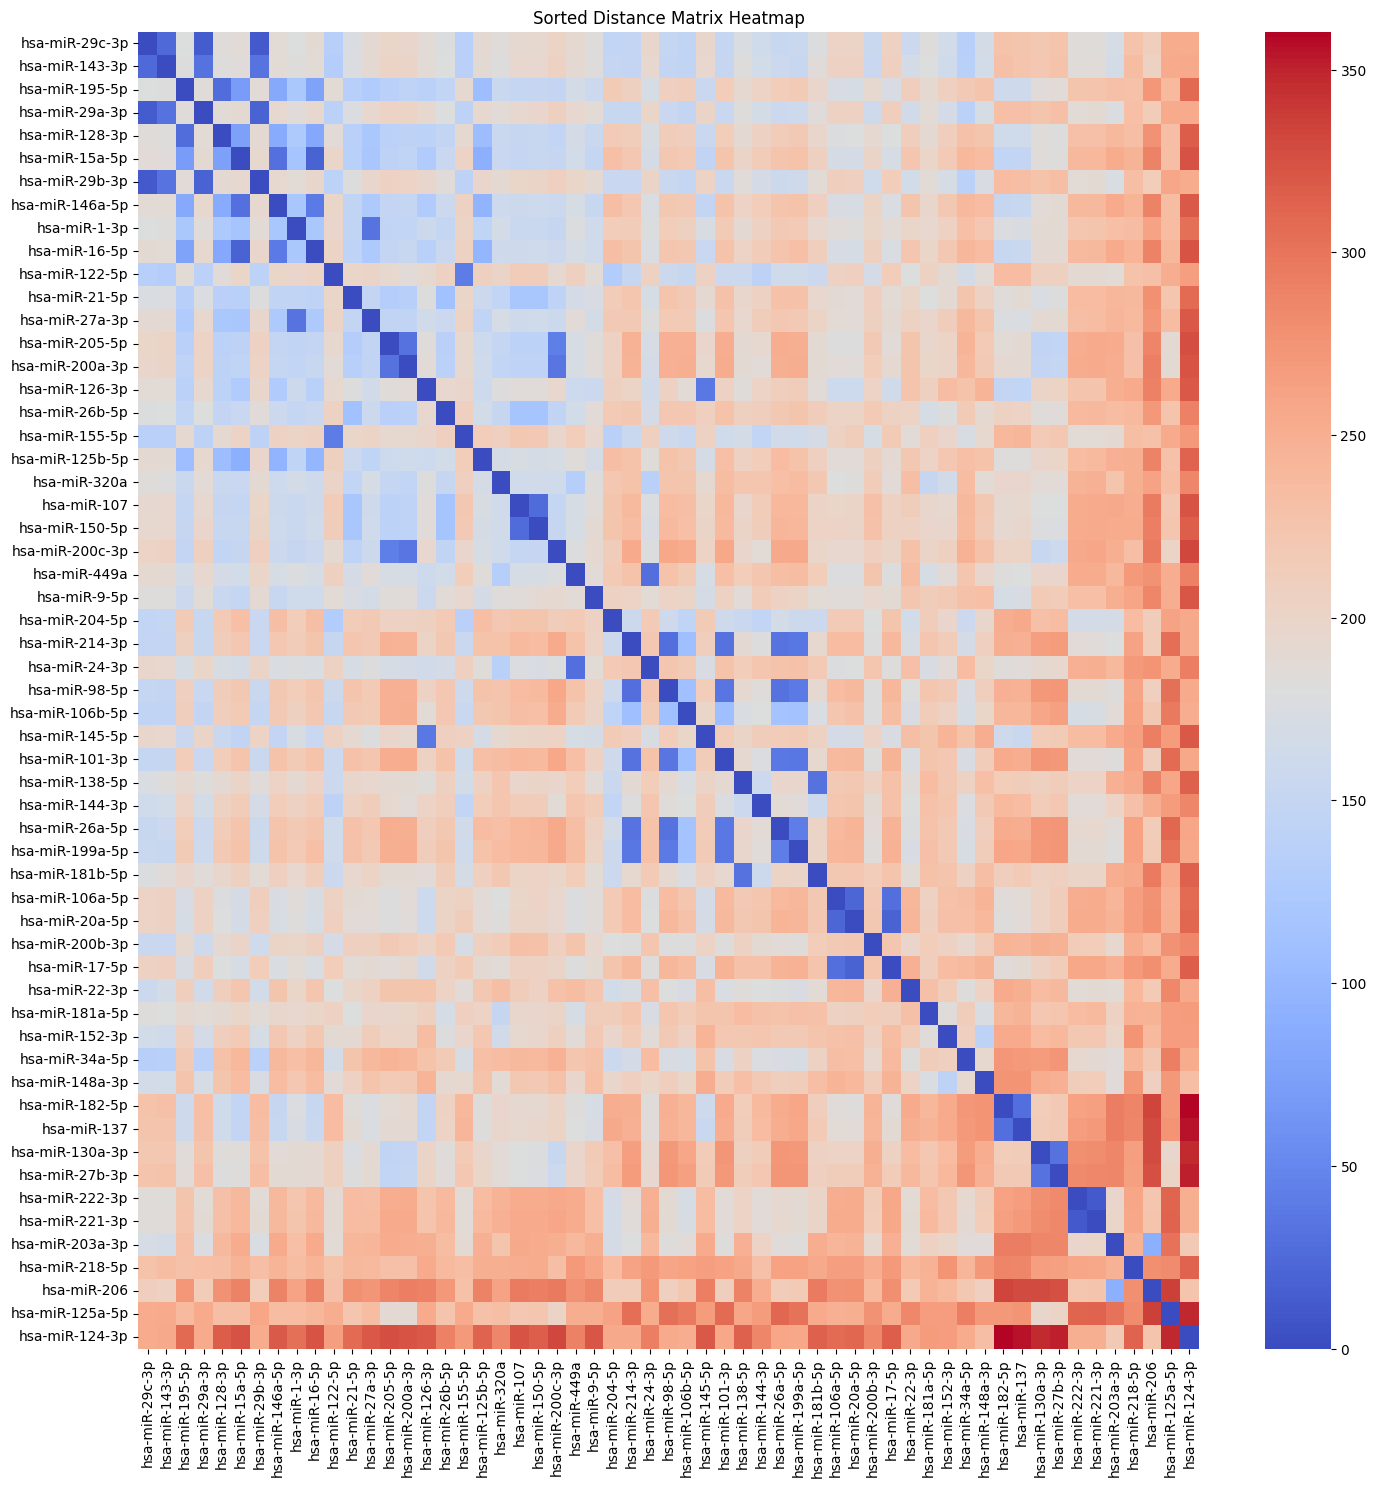

In [17]:
dist_df = my_network.get_mirnas_similarity()
mi_plot.plot_mirnas_similarirty(dist_df)


In [18]:
len(my_network.miR_nodes)/3

19.0

In [19]:
n_clusters= len(my_network.miR_nodes)//3
mirna_clusters = jf.cluster_mirnas(dist_matrix_square=dist_df, n_clusters=n_clusters)
minas_cluster = mirna_clusters.sort_values(by=["Cluster"])['Cluster']

Cluster labels:
 [ 5  0  0 17 16 17 17  4  2  6 17 13 13 13  8  8  4  5  0  0  0  0  9 14
 10 18 11 11 18 16 10 10  1  7  2  0 12 12  3  7  0  1 10  3  6 14 18 10
 15  4 15  1  3  4 10  9  1]


/home/karen/Documents/GitHub/Muscle_wasting/venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:310: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [53]:
minas_cluster

hsa-miR-15a-5p      0
hsa-miR-16-5p       0
hsa-miR-200b-3p     0
hsa-miR-125b-5p     0
hsa-miR-125a-5p     0
hsa-miR-9-5p        0
hsa-miR-218-5p      0
hsa-miR-146a-5p     0
hsa-miR-22-3p       1
hsa-miR-34a-5p      1
hsa-miR-204-5p      1
hsa-miR-144-3p      1
hsa-miR-181b-5p     2
hsa-miR-138-5p      2
hsa-miR-124-3p      3
hsa-miR-148a-3p     3
hsa-miR-152-3p      3
hsa-miR-26b-5p      4
hsa-miR-320a        4
hsa-miR-21-5p       4
hsa-miR-181a-5p     4
hsa-miR-122-5p      5
hsa-miR-155-5p      5
hsa-miR-206         6
hsa-miR-203a-3p     6
hsa-miR-137         7
hsa-miR-182-5p      7
hsa-miR-222-3p      8
hsa-miR-221-3p      8
hsa-miR-27a-3p      9
hsa-miR-1-3p        9
hsa-miR-199a-5p    10
hsa-miR-106b-5p    10
hsa-miR-214-3p     10
hsa-miR-98-5p      10
hsa-miR-101-3p     10
hsa-miR-26a-5p     10
hsa-miR-449a       11
hsa-miR-24-3p      11
hsa-miR-126-3p     12
hsa-miR-145-5p     12
hsa-miR-106a-5p    13
hsa-miR-20a-5p     13
hsa-miR-17-5p      13
hsa-miR-107        14
hsa-miR-15

In [20]:
clustered_mirnas = {}
for mirna in mirnas:
    if mirna in minas_cluster.index:
        cluster = minas_cluster[mirna]
        if cluster not in clustered_mirnas:
            cluster=int(cluster)
            clustered_mirnas[cluster] = []
        clustered_mirnas[cluster].append(mirna)
clustered_mirnas

{0: ['hsa-miR-15a-5p', 'hsa-miR-218-5p'],
 15: ['hsa-miR-130a-3p'],
 6: ['hsa-miR-206'],
 13: ['hsa-miR-17-5p', 'hsa-miR-20a-5p', 'hsa-miR-106a-5p'],
 2: ['hsa-miR-138-5p'],
 14: ['hsa-miR-150-5p', 'hsa-miR-107'],
 3: ['hsa-miR-124-3p']}

Now that the mirnas are assiged to a cluster, we can proceed with the plot of the smaller networks.
This will be the microRNAs and the genes they reached on the random walk. 
On the plot we also add the pathway enrichment of the targets reached for that mirna.
This it done in 2 ways, mirna indoviodually and by cluster.


In [21]:

if "msigdb.csv" in os.listdir('mirkitten/data'):
    msigdb = pd.read_csv('mirkitten/data/msigdb.csv', index_col = 0)
msigdb.index = msigdb['genesymbol']
sel_db = ['go_molecular_function',
                      'go_cellular_component',
                      'go_biological_process',
                      'reactome_pathways',
                      'kegg_pathways', 'hallmark']
msigdb =msigdb[msigdb['collection'].isin(sel_db)]
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
      

mirna_scoring/results/UseCase_2/hsa-miR-15a-5p.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-15a-5p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_2/hsa-miR-130a-3p.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-130a-3p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_2/hsa-miR-206.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-206.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_2/hsa-miR-17-5p.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-17-5p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_2/hsa-miR-138-5p.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-138-5p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_2/hsa-miR-218-5p.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-218-5p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_2/hsa-miR-150-5p.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-150-5p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_2/hsa-miR-20a-5p.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-20a-5p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_2/hsa-miR-107.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-107.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_2/hsa-miR-124-3p.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-124-3p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_2/hsa-miR-106a-5p.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-106a-5p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


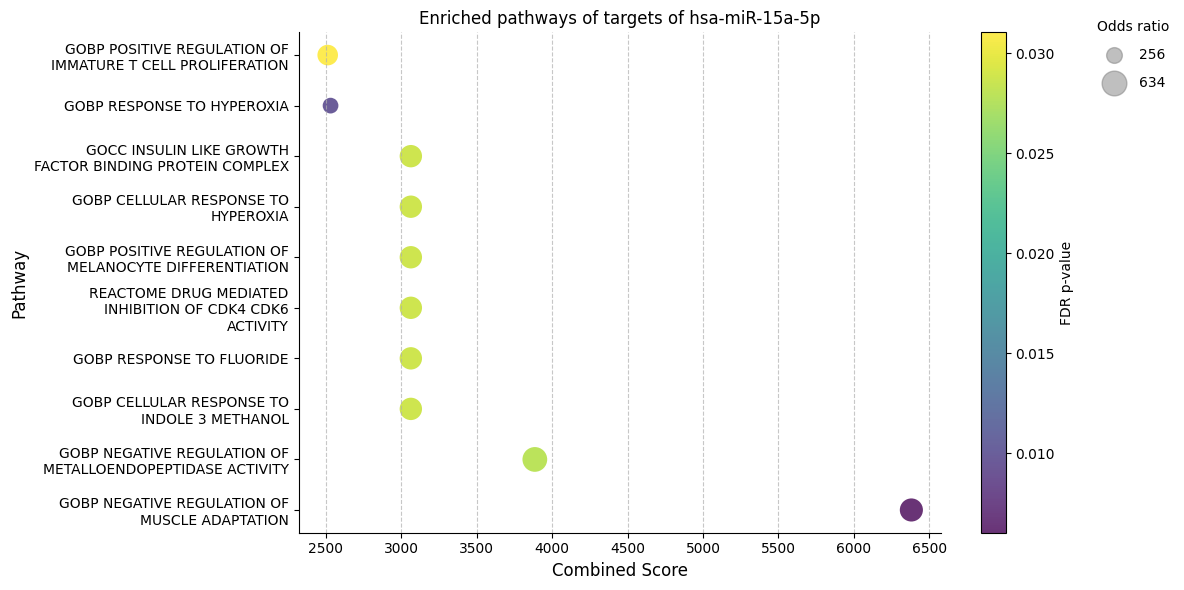

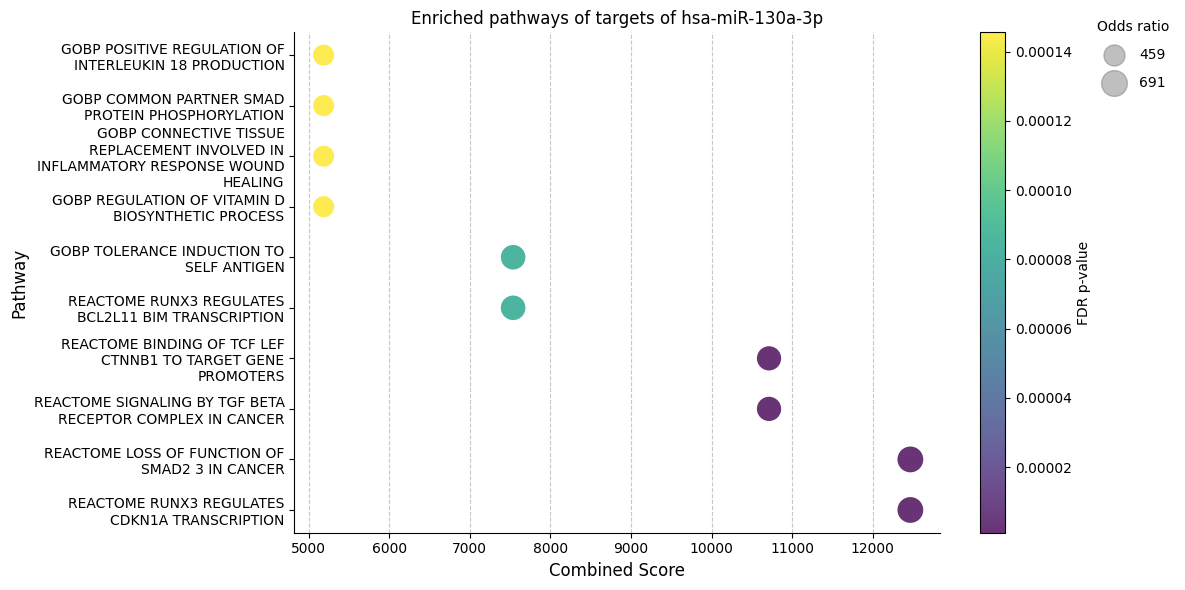

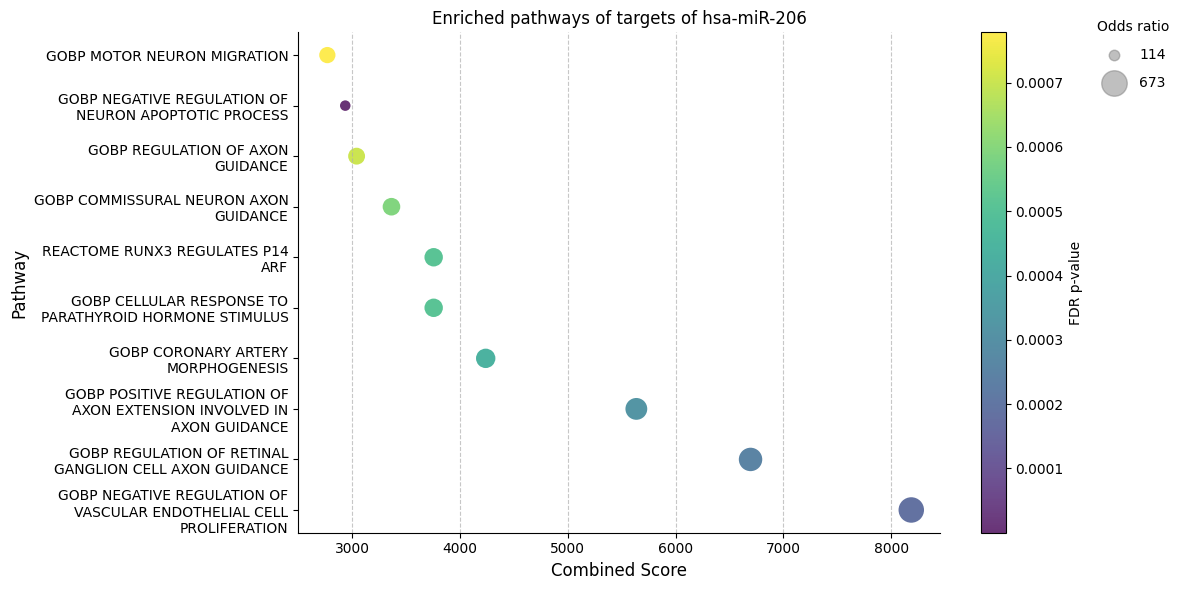

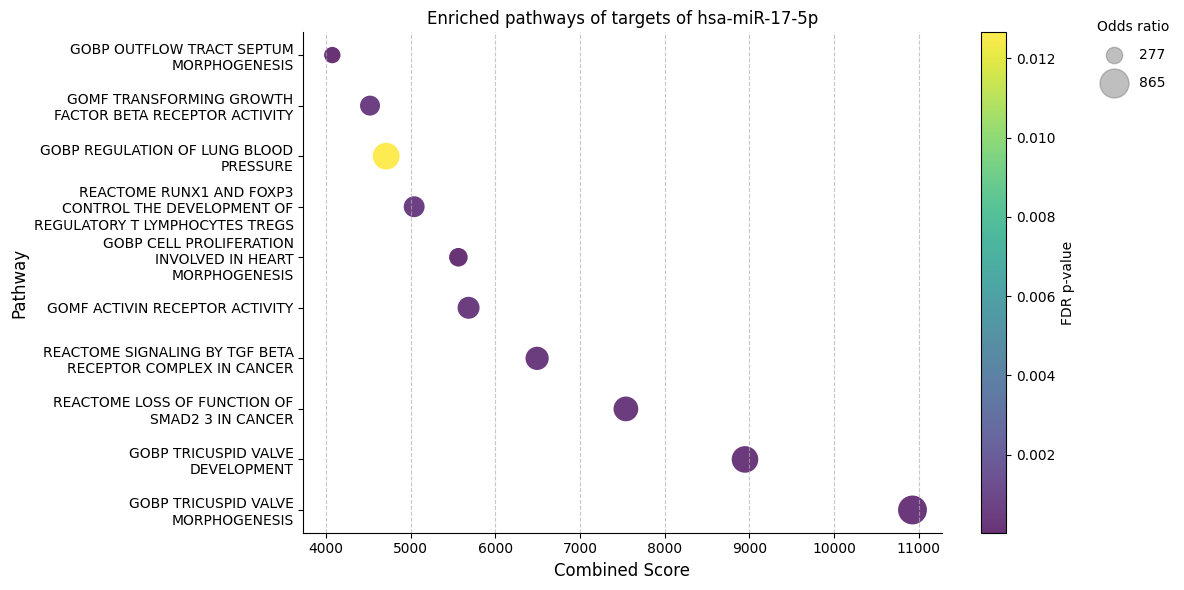

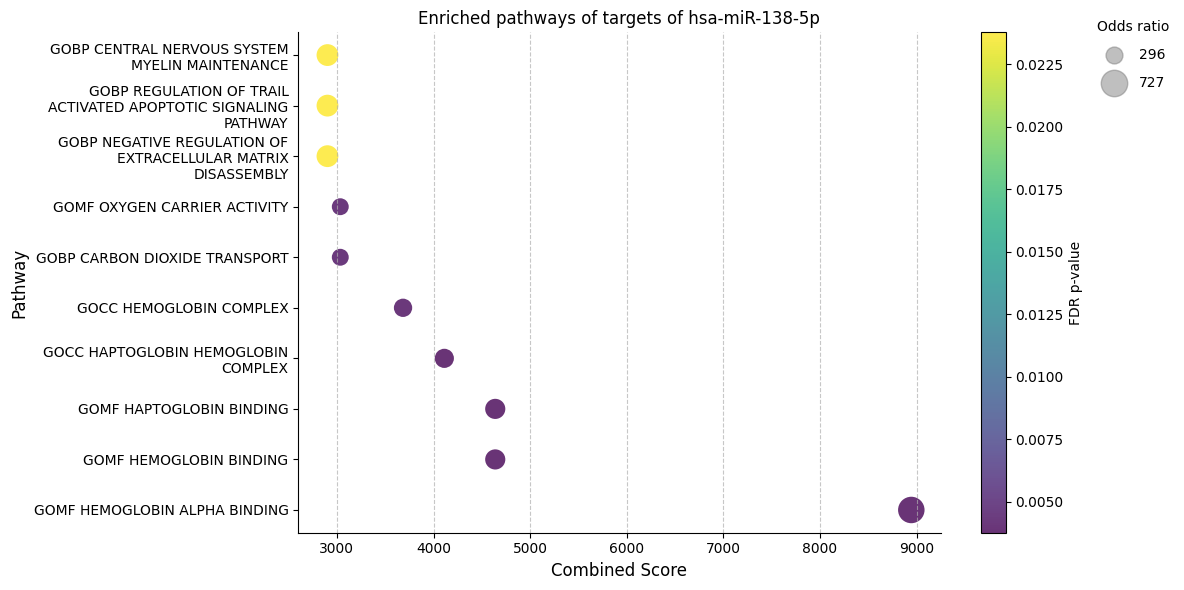

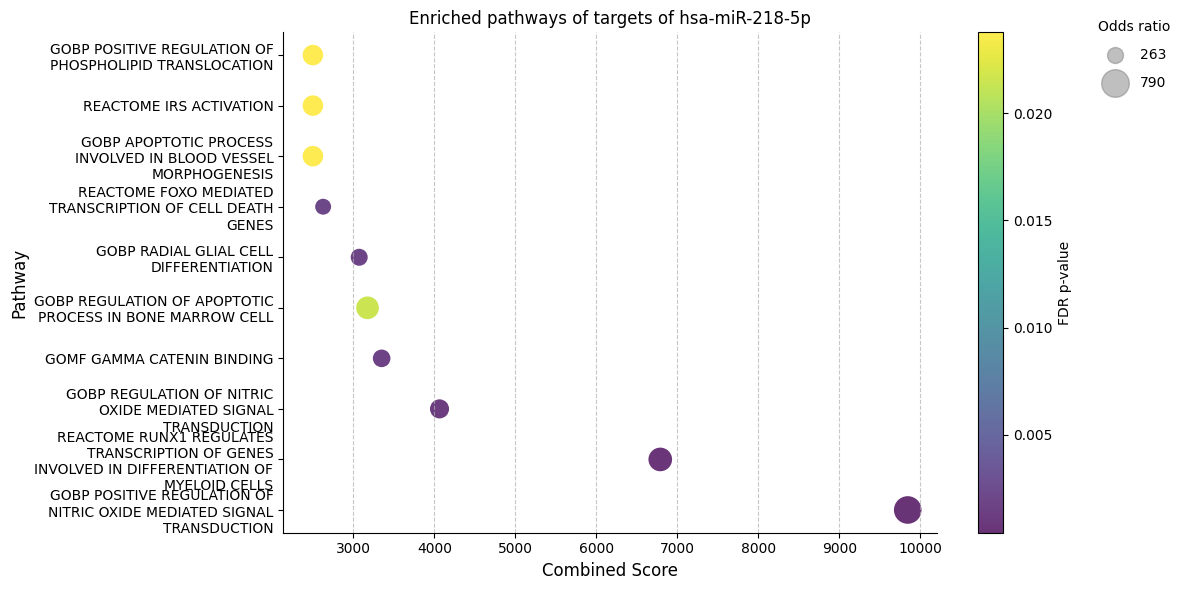

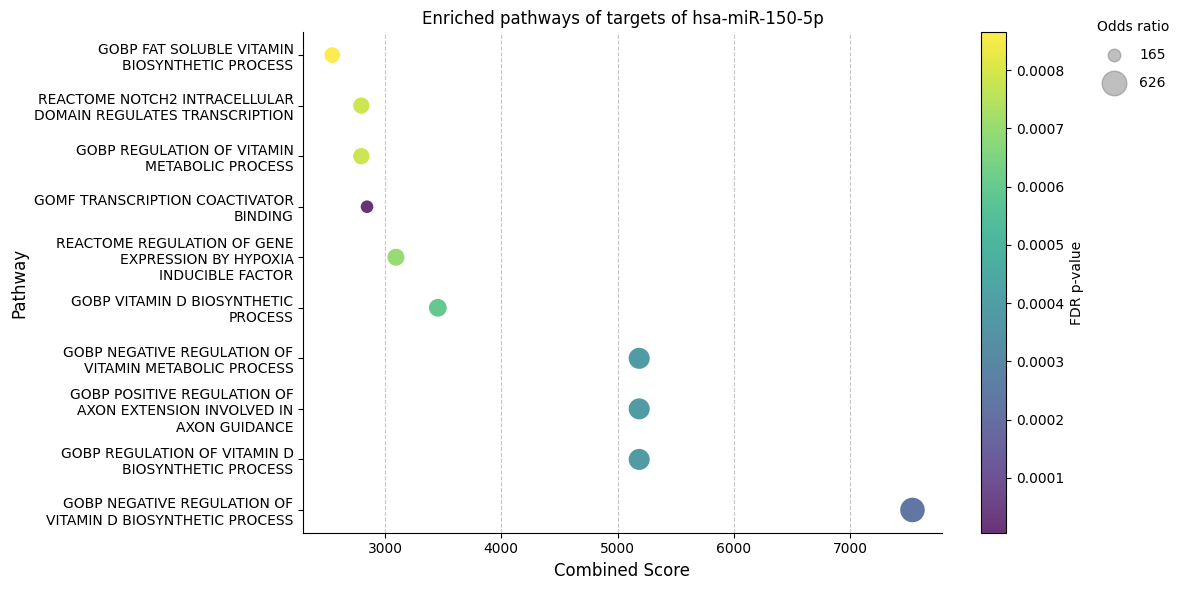

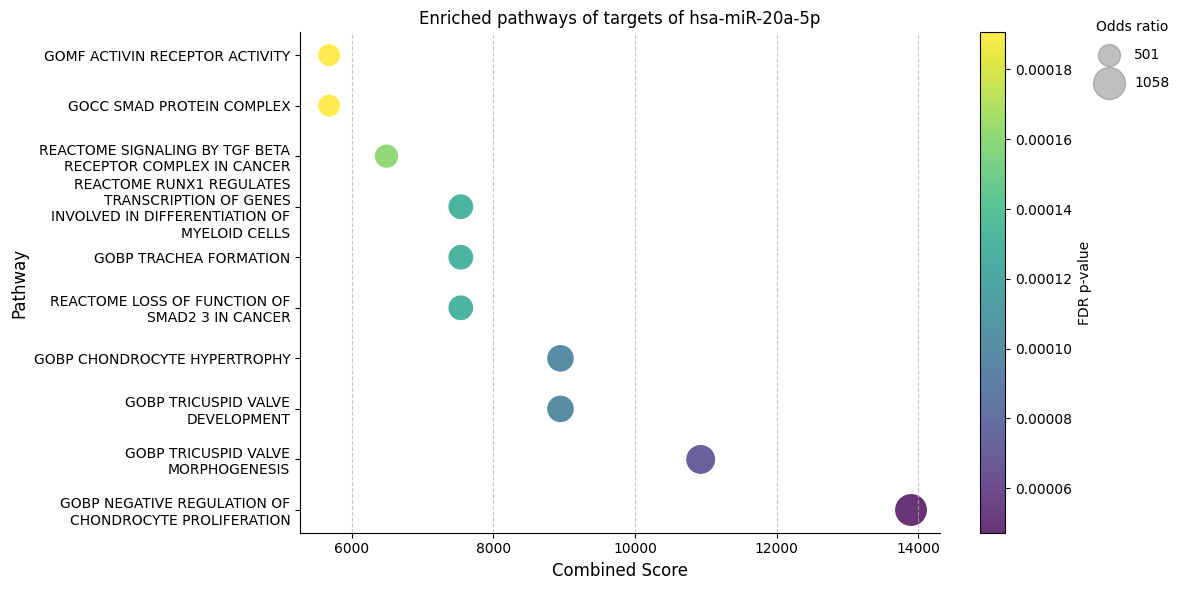

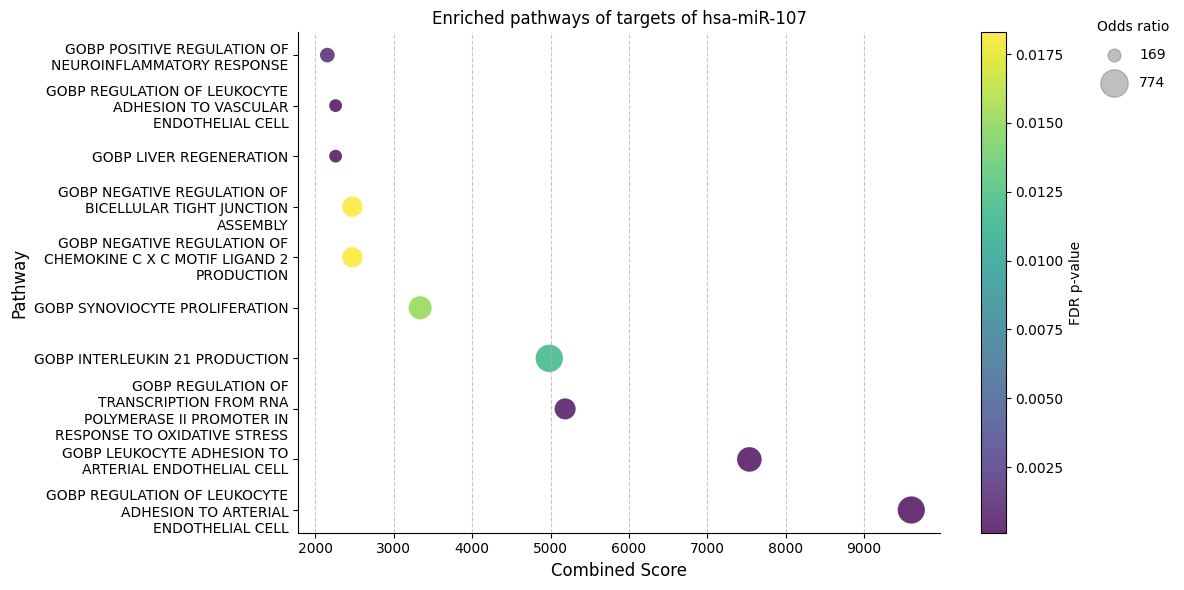

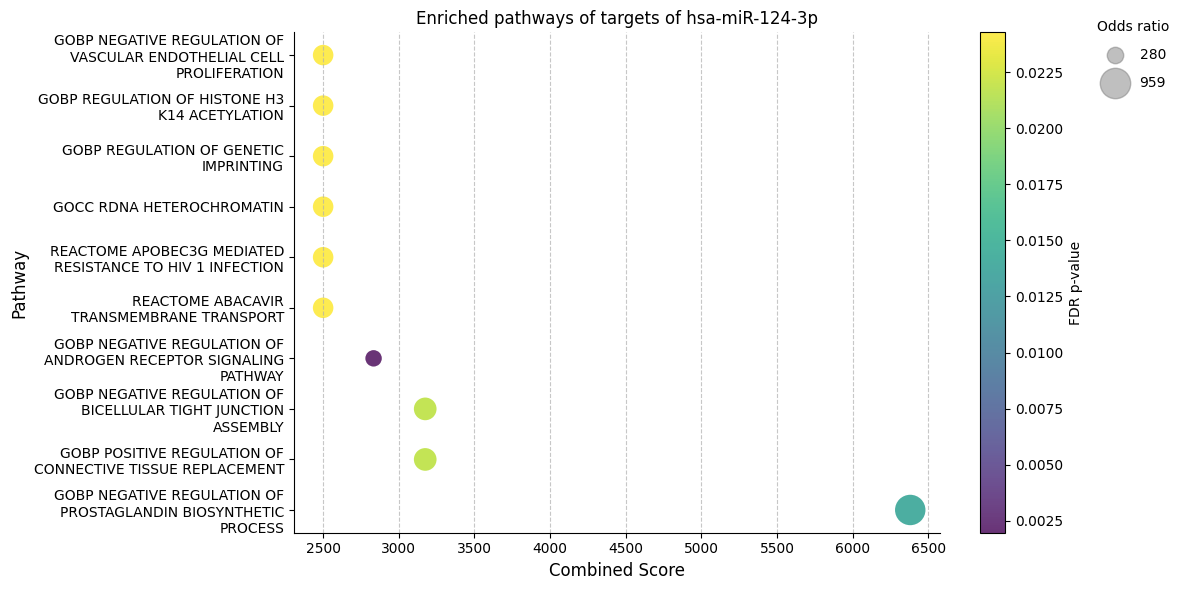

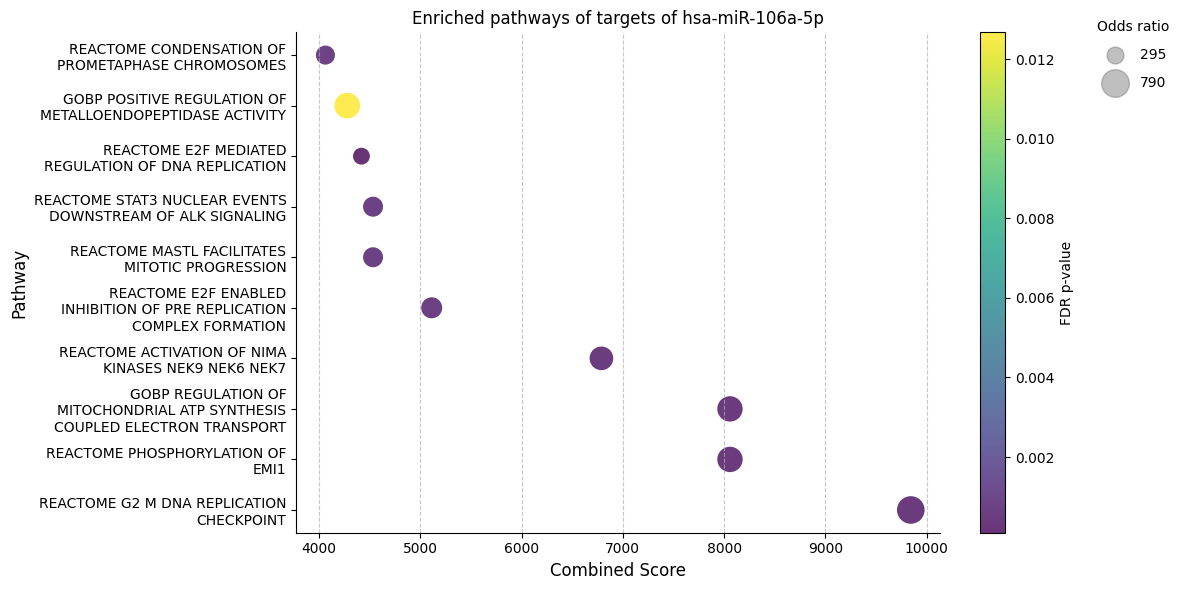

In [22]:
genes = []
for mirna in mirnas:
    paths = my_network.mirnas_paths[mirna]
    sub_network=[]
    for path in paths:
        sub_network.extend(path)
        genes.extend(path)
    sub_network=list(set(sub_network))
    #mi_plot.draw_network(G=my_network.network, node_list = sub_network, name= mirna, save_path='mirna_scoring/sub_plots')
    html_file = mi_plot.generate_html_network_report(network=my_network.network, selected_nodes=sub_network, name=mirna, save_path=directory)
    #fig, ax = get_plot_enriched(sub_network, f"Enriched pathways of targets of {mirna}")
    fig, ax = get_mirna_target_enriched(selected_genes=sub_network, title=f"Enriched pathways of targets of {mirna}", msigdb=msigdb)
    image_file = html_file.split('/')[-1]
    html_image_path = f'{image_file}_PathwayEnriched.png'
    image_file = f'{directory}/{image_file}_PathwayEnriched.png'
    fig.savefig(image_file, dpi=300, bbox_inches='tight')
    
    with open(html_file, "r") as file:
        html_content = file.read()

    # Append the image tag to the HTML
    html_content += f"""
    <h2>Enriched Pathways</h2>
    <img src="{html_image_path}" alt="Enriched Pathways">
    """
    
    # Save the modified HTML file
    with open(html_file, "w") as file:
        file.write(html_content)

22
mirna_scoring/results/UseCase_2/hsa-miR-218-5p_cluster_0.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-218-5p_cluster_0.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


16
mirna_scoring/results/UseCase_2/hsa-miR-130a-3p_cluster_15.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-130a-3p_cluster_15.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


15
mirna_scoring/results/UseCase_2/hsa-miR-206_cluster_6.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-206_cluster_6.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


33
mirna_scoring/results/UseCase_2/hsa-miR-106a-5p_cluster_13.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-106a-5p_cluster_13.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


14
mirna_scoring/results/UseCase_2/hsa-miR-138-5p_cluster_2.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-138-5p_cluster_2.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


32
mirna_scoring/results/UseCase_2/hsa-miR-107_cluster_14.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-107_cluster_14.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


13
mirna_scoring/results/UseCase_2/hsa-miR-124-3p_cluster_3.html
Saved on mirna_scoring/results/UseCase_2/hsa-miR-124-3p_cluster_3.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


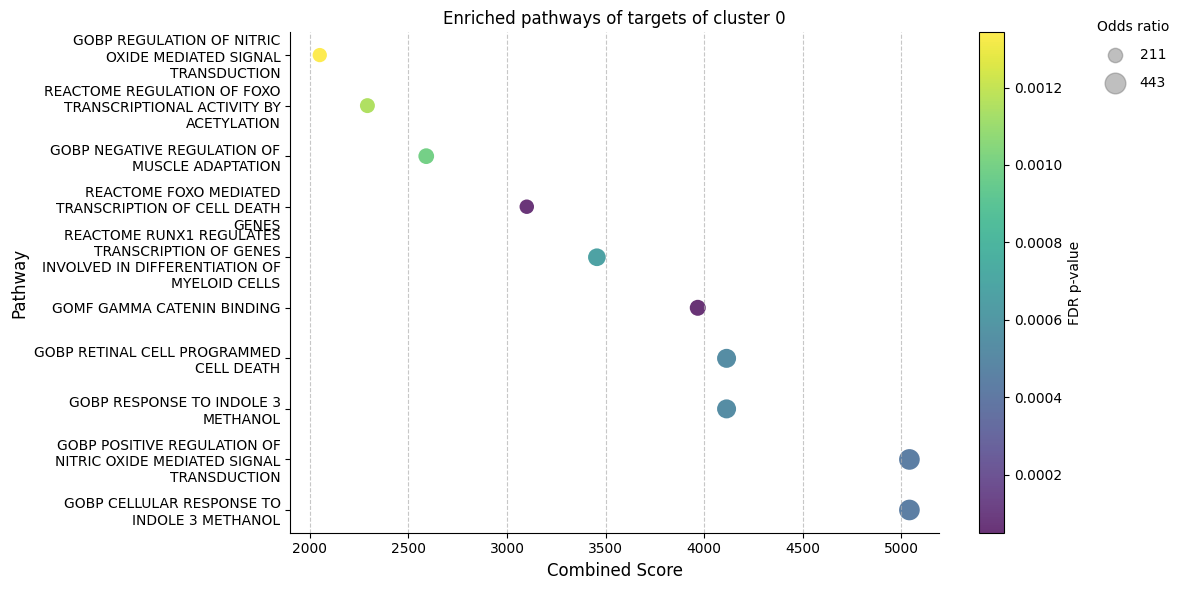

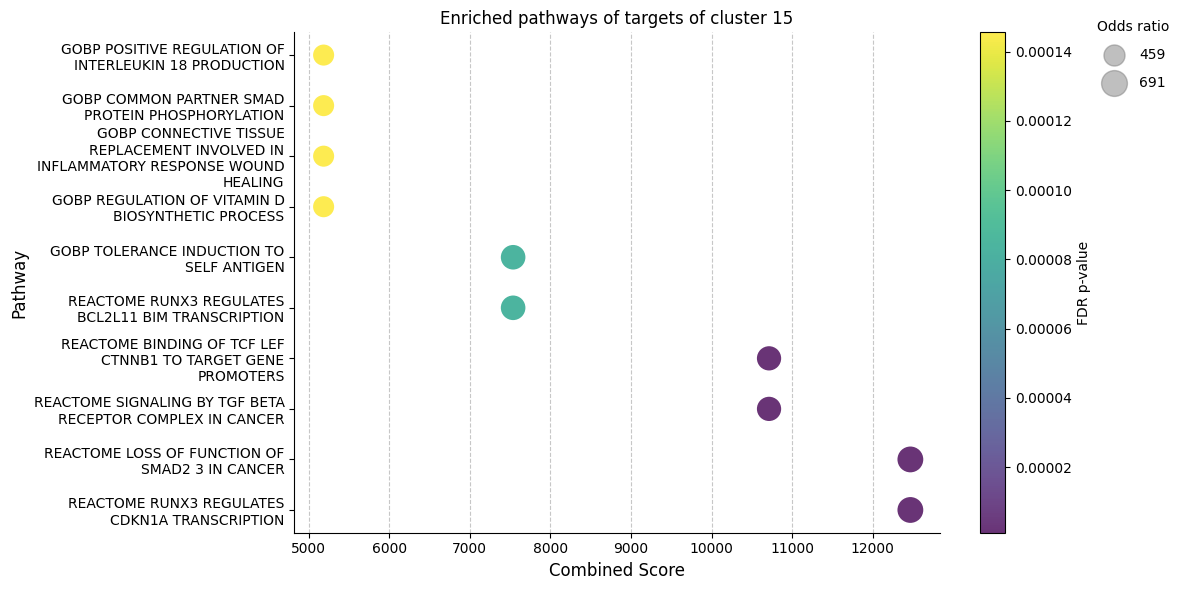

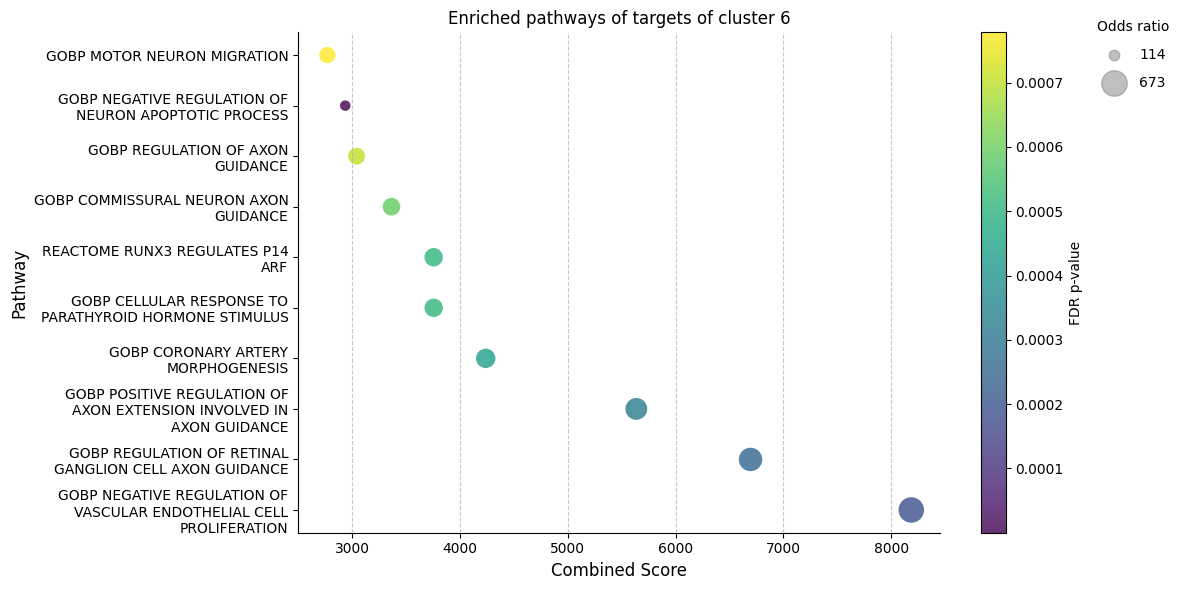

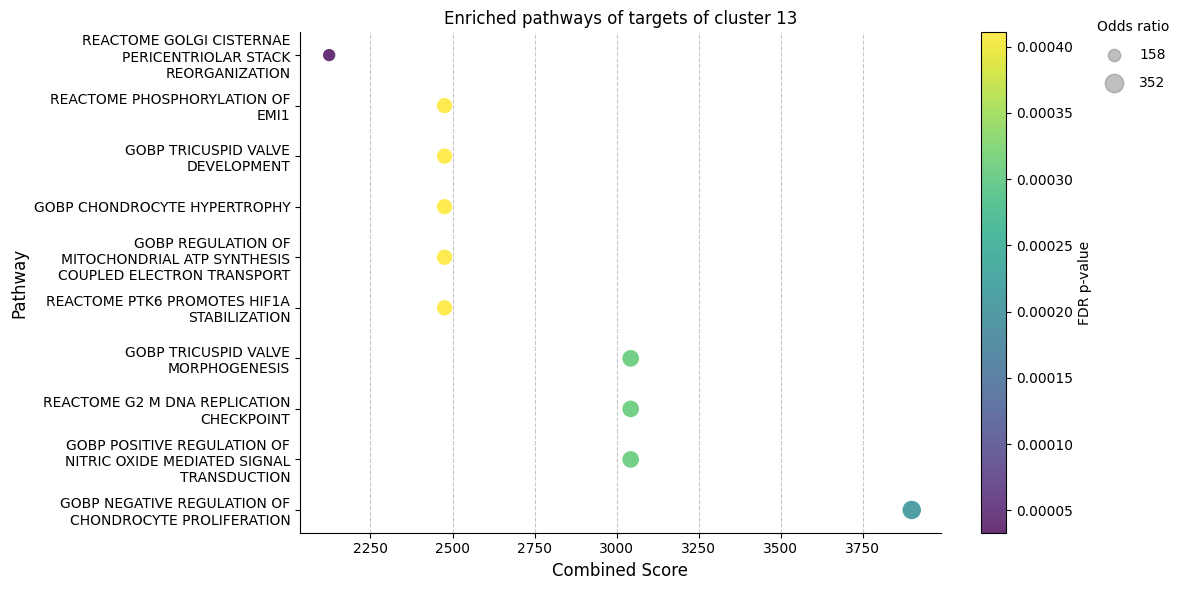

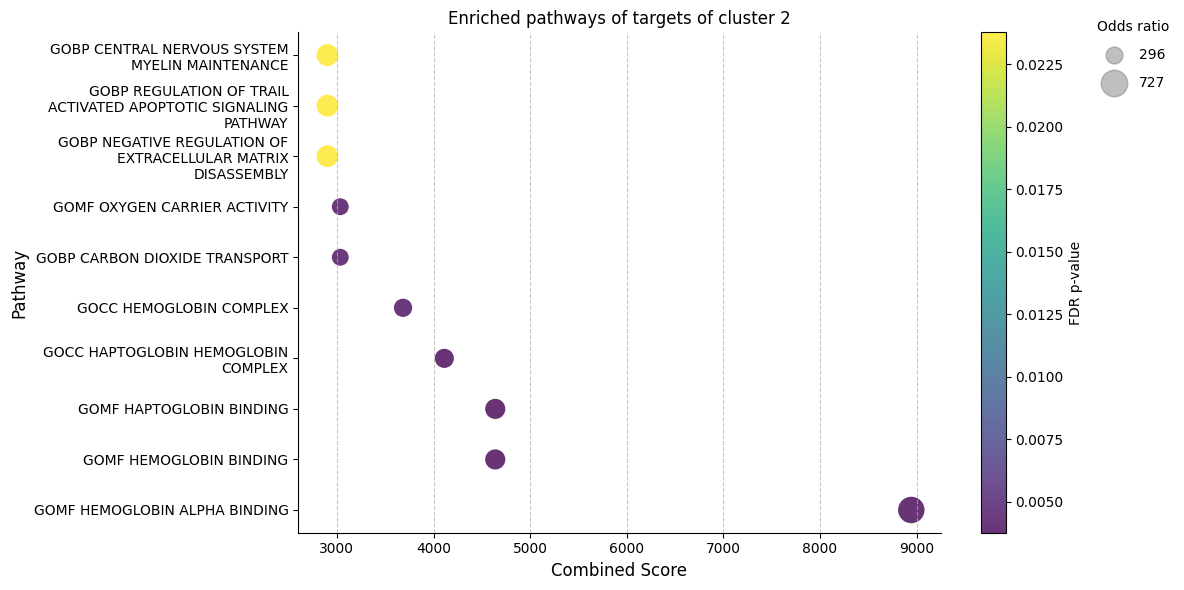

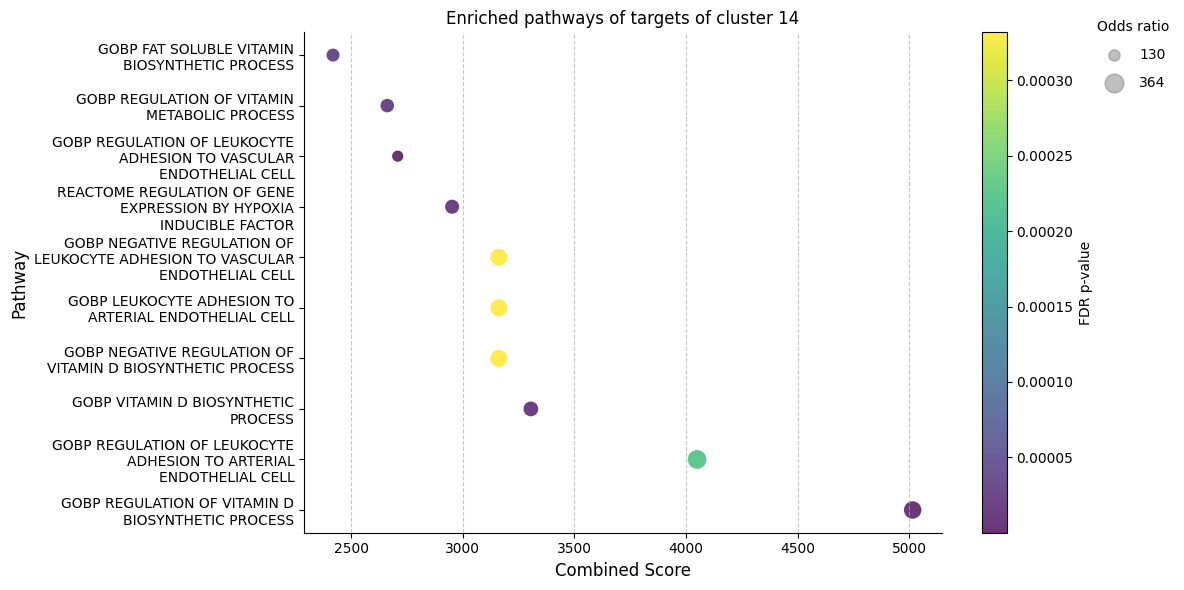

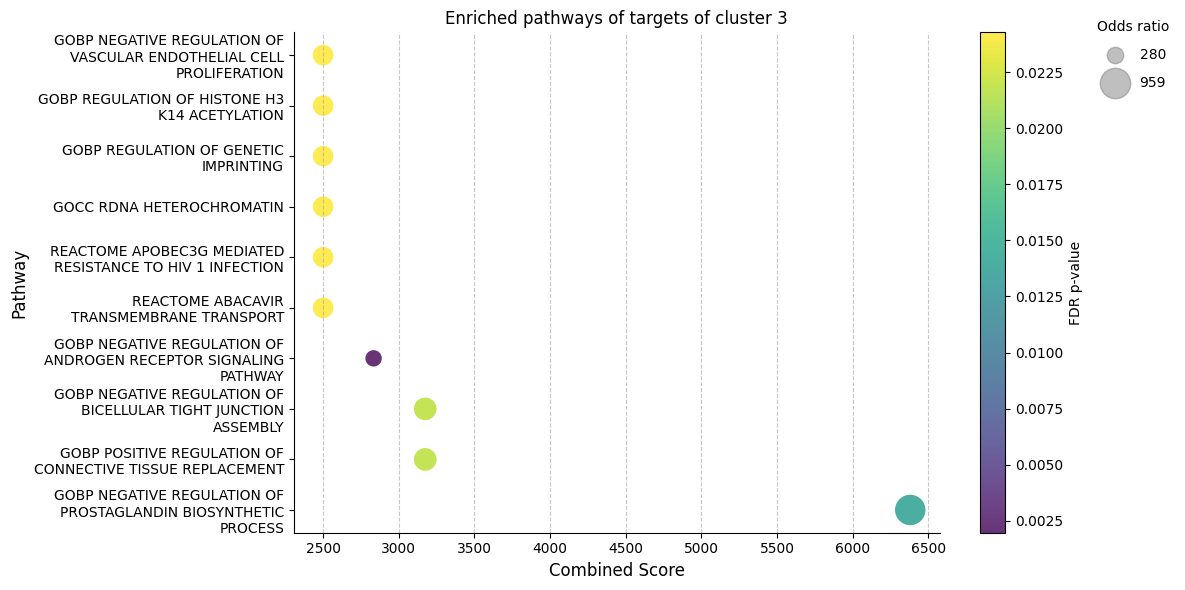

In [52]:
for cluster, mirnas in clustered_mirnas.items():
    sub_network_cluster=[]
    impacts=[]
    for mirna in mirnas:
        paths = my_network.mirnas_paths[mirna]
        for path in paths:
            sub_network_cluster.extend(path)
        impact = my_network.influence_sum_df.loc[mirna]
        impacts.append(impact)
    sub_network_cluster=list(set(sub_network_cluster))
    impacts = pd.DataFrame(impacts)
    genes = [gene for gene in sub_network_cluster if gene in impacts.columns]
    impacts = impacts[genes]
    impacts = impacts.reset_index()
    print(len(sub_network_cluster))
    mi_plot.generate_html_network_report(network=my_network.network, selected_nodes=sub_network_cluster, name=mirna+f"_cluster_{cluster}",influences=impacts.round(3), save_path=directory)
    #mi_plot.draw_network(G=my_network.network, node_list = sub_network_cluster, name= mirna+f"_cluster_{cluster}", save_path='mirna_scoring/sub_plots')
    html_file = f"{directory}/{mirna}_cluster_{cluster}.html"
    fig, ax = get_plot_enriched(sub_network_cluster, f"Enriched pathways of targets of cluster {cluster}")
    image_file = html_file.split('/')[-1]
    html_image_path = f'{image_file}_PathwayEnriched.png'
    image_file = f'{directory}/{image_file}_PathwayEnriched.png'
    fig.savefig(image_file, dpi=300, bbox_inches='tight')
    
    with open(html_file, "r") as file:
        html_content = file.read()

    # Append the image tag to the HTML
    html_content += f"""
    <h2>Enriched Pathways</h2>
    <img src="{html_image_path}" alt="Enriched Pathways">

    <h4> Filter to see in cytoscape: </h4>
    """
    html_content += jf.get_cytoscape_filter_from_list(sub_network_cluster)
    # Save the modified HTML file
    with open(html_file, "w") as file:
        file.write(html_content)

In [24]:
genes = list(set(genes))

If the user desires to see the genes selected on the output of miRKat Network, it can be done using the filters, the program already gives the filter to use, just to copy and paste :)

In [25]:
jf.get_cytoscape_filter_from_list(genes)

'(ROCK1)|(SIRT1)|(MCL1)|(CCL2)|(SPHK1)|(CD151)|(MTDH)|(HMGA1)|(CDK4)|(PIK3CA)|(SMARCA4)|(ABCG2)|'

Finally, we can have a look on the enriched pathways on the network overall

In [26]:
enriched = dc.get_ora_df(
            df=genes,
            net=msigdb,
            source='geneset',
            target='genesymbol'
        )

In [27]:
pathway_df = enriched[enriched['FDR p-value'] < 0.1]
pathway_df.index = pathway_df["Term"]
#pathway_df.set_index("Term", inplace=True)  # Set "Term" as index
enriched_pathways = pathway_df['Combined score']

In [28]:
enriched_pathways

Term
GOBP_ACTIN_FILAMENT_BASED_MOVEMENT                                         224.219660
GOBP_ACTIN_FILAMENT_DEPOLYMERIZATION                                       150.015183
GOBP_ACTIN_FILAMENT_ORGANIZATION                                            38.377125
GOBP_ACTIN_MEDIATED_CELL_CONTRACTION                                       308.095514
GOBP_ACYLGLYCEROL_HOMEOSTASIS                                              256.401073
                                                                             ...     
REACTOME_TRANSCRIPTIONAL_REGULATION_OF_GRANULOPOIESIS                      146.751217
REACTOME_TRANSCRIPTIONAL_REGULATION_OF_WHITE_ADIPOCYTE_DIFFERENTIATION      92.553727
REACTOME_TYPE_I_HEMIDESMOSOME_ASSEMBLY                                    1138.933411
REACTOME_UNFOLDED_PROTEIN_RESPONSE_UPR                                      82.022718
REACTOME_VEGFR2_MEDIATED_CELL_PROLIFERATION                                598.655148
Name: Combined score, Length: 1180, dtype: float6

In [29]:
pathway_df

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
Term,,,,,,,,
GOBP_ACTIN_FILAMENT_BASED_MOVEMENT,GOBP_ACTIN_FILAMENT_BASED_MOVEMENT,126,0.015873,0.002494,0.020075,37.407303,224.219660,PIK3CA;ROCK1
GOBP_ACTIN_FILAMENT_DEPOLYMERIZATION,GOBP_ACTIN_FILAMENT_DEPOLYMERIZATION,58,0.017241,0.034260,0.066192,44.464883,150.015183,PIK3CA
GOBP_ACTIN_FILAMENT_ORGANIZATION,GOBP_ACTIN_FILAMENT_ORGANIZATION,437,0.004577,0.027199,0.059270,10.646803,38.377125,PIK3CA;ROCK1
GOBP_ACTIN_MEDIATED_CELL_CONTRACTION,GOBP_ACTIN_MEDIATED_CELL_CONTRACTION,99,0.020202,0.001550,0.014940,47.622637,308.095514,PIK3CA;ROCK1
GOBP_ACYLGLYCEROL_HOMEOSTASIS,GOBP_ACYLGLYCEROL_HOMEOSTASIS,38,0.026316,0.022569,0.053276,67.631282,256.401073,SIRT1
...,...,...,...,...,...,...,...,...
REACTOME_TRANSCRIPTIONAL_REGULATION_OF_GRANULOPOIESIS,REACTOME_TRANSCRIPTIONAL_REGULATION_OF_GRANULO...,59,0.016949,0.034841,0.066942,43.715382,146.751217,CDK4
REACTOME_TRANSCRIPTIONAL_REGULATION_OF_WHITE_ADIPOCYTE_DIFFERENTIATION,REACTOME_TRANSCRIPTIONAL_REGULATION_OF_WHITE_A...,84,0.011905,0.049265,0.081951,30.743247,92.553727,CDK4
REACTOME_TYPE_I_HEMIDESMOSOME_ASSEMBLY,REACTOME_TYPE_I_HEMIDESMOSOME_ASSEMBLY,11,0.090909,0.006582,0.029057,226.724008,1138.933411,CD151


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


(<Figure size 1200x800 with 2 Axes>,
 <Axes: title={'center': 'Top 10 ORA Results by Combined Score'}, xlabel='Combined Score', ylabel='Pathway'>)

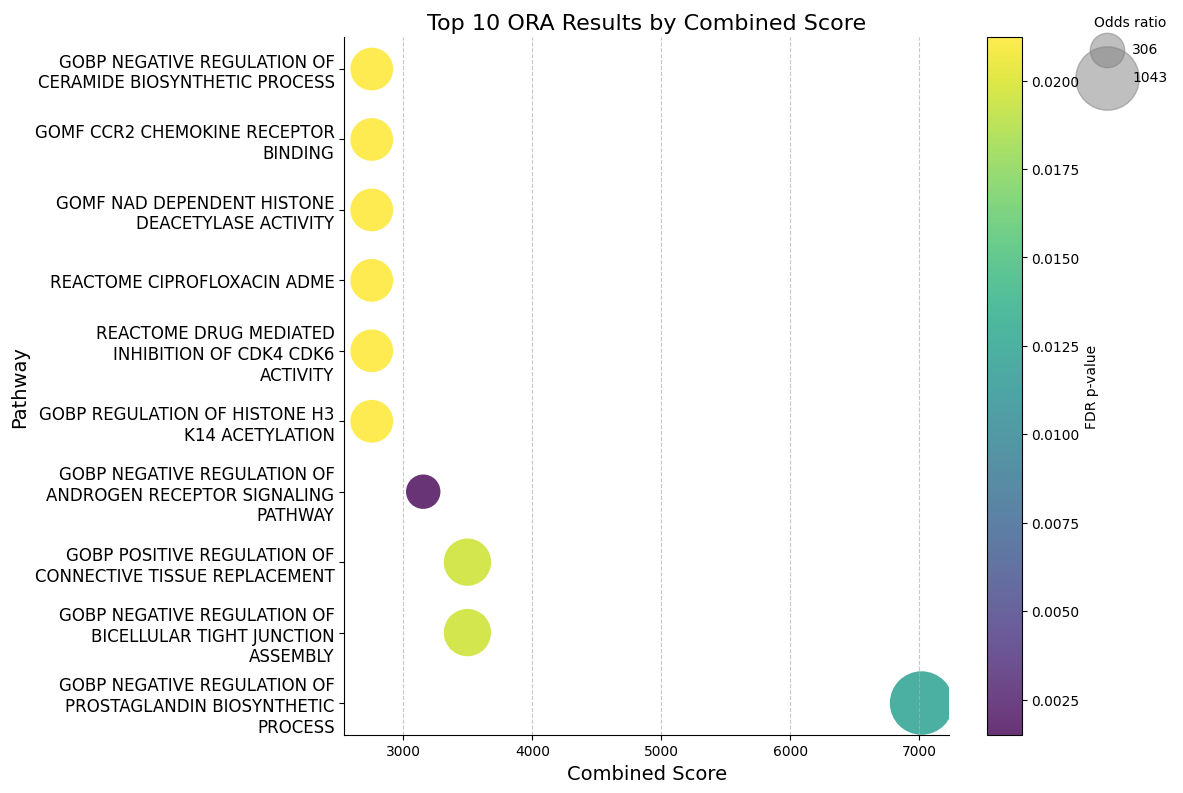

In [30]:
plot_ora_results(pathway_df, top_n=10, figsize=(12, 8), scale_odds_ratio=2, 
                     fontsize_title=16, fontsize_subtitle=14, fontsize_text=12,)

In [31]:
pathway_df_no_cancer = pathway_df[~pathway_df['Term'].str.contains('cancer', case=False)]

/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


(<Figure size 1000x600 with 2 Axes>,
 <Axes: title={'center': 'Top 10 ORA Results by Combined Score'}, xlabel='Combined Score', ylabel='Pathway'>)

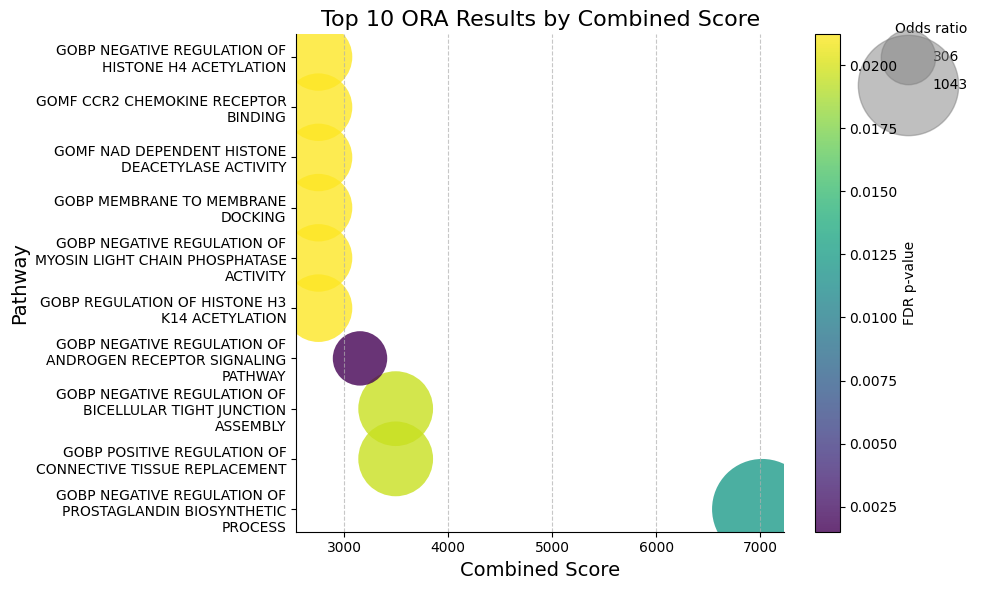

In [32]:
plot_ora_results(pathway_df_no_cancer, top_n=10, figsize=(10, 6), scale_odds_ratio=5, 
                     fontsize_title=16, fontsize_subtitle=14, fontsize_text=10,)

In [38]:
mirnas

['hsa-miR-124-3p']

Plot the clusters

/home/karen/Documents/GitHub/Muscle_wasting/venv/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/karen/Documents/GitHub/Muscle_wasting/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/karen/Documents/GitHub/Muscle_wasting/venv/lib/python3.11/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/tmp/ipykernel_188473/678075864.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (plot_df['UMAP1'][i], plot_df['UMAP2'][i]), fontsize=8, alpha=0

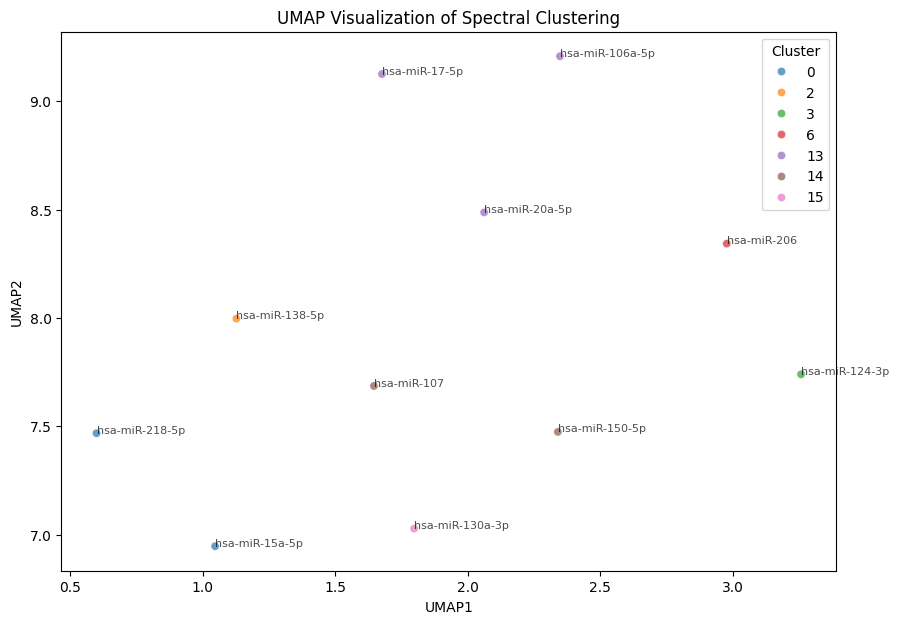

In [44]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
selected_dist_df = dist_df.loc[mirnas_selected, mirnas_selected]
# Compute UMAP embedding
reducer = umap.UMAP(metric="precomputed", random_state=42)
embedding = reducer.fit_transform(selected_dist_df)

# Create a dataframe with UMAP results and cluster labels

plot_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'], index=selected_dist_df.index)
plot_df['Cluster'] = mirna_clusters['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster', data=plot_df, palette='tab10', alpha=0.7)

# Add labels for each miRNA
for i, txt in enumerate(plot_df.index):
    plt.annotate(txt, (plot_df['UMAP1'][i], plot_df['UMAP2'][i]), fontsize=8, alpha=0.7)

plt.title("UMAP Visualization of Spectral Clustering")
plt.legend(title="Cluster", bbox_to_anchor=(1, 1))
plt.show()


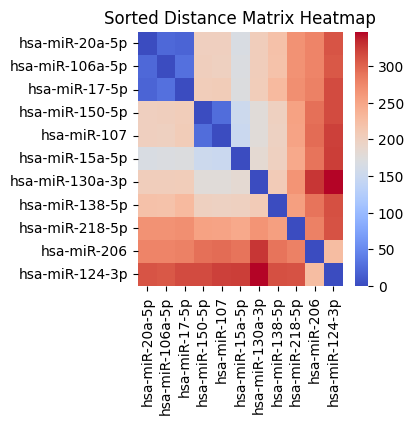

In [45]:
mi_plot.plot_mirnas_similarirty(selected_dist_df)

In [35]:

my_network.influence_df.loc['hsa-miR-34a-5p']['AXIN2']

[-1.0,
 -0.3333333333333333,
 -0.05555555555555555,
 -0.05263157894736842,
 0.041666666666666664,
 -0.022727272727272728,
 -0.0196078431372549,
 0.018518518518518517,
 0.009900990099009901,
 -0.007936507936507936,
 -0.0078125,
 -0.007751937984496124,
 -0.008333333333333333]

In [36]:
from fractions import Fraction

# Get the float value
float_values = my_network.influence_df.loc['hsa-miR-34a-5p']['AXIN2']
fractions= []
for float_value in float_values:
    fraction = Fraction(float_value).limit_denominator(100)
    fraction_str = f"{fraction.numerator}/{fraction.denominator}"
    fractions.append(fraction_str)

In [37]:
fractions

['-1/1',
 '-1/3',
 '-1/18',
 '-1/19',
 '1/24',
 '-1/44',
 '-1/51',
 '1/54',
 '1/100',
 '-1/100',
 '-1/100',
 '-1/100',
 '-1/100']